In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import signal
import matplotlib.mlab as mlab
import pymc3 as pm

asd_file = "asd.txt"
asd_columns=["freq","strain"]
gw_columns=["time", "h_plus", "h_cross", "h_H1", "h_L1"]



In [2]:
def read_file(filename,columns):
    # MAKE MORE EFFICIENTTTT
    file_dict={}
    f = open(filename,"r") 
    f_read=f.readlines()
    for line in f_read[1:]:
        split_line=line.split()
        for i in range(len(columns)):
            try:
                file_dict[columns[i]].append(float(split_line[i]))
            except:
                file_dict[columns[i]]=[float(split_line[i])]
                
    for i in range(len(columns)):
        file_dict[columns[i]]=np.array(file_dict[columns[i]])
    return file_dict

# reads in the waveform files
GW150914_median_data=read_file("waveforms/GW150914_median.txt",gw_columns)
#GW150914_aligned_data=read_file("waveforms/GW151226_aligned.txt",gw_columns)
#LVT151012_aligned_data=read_file("waveforms/LVT151012_aligned.txt",gw_columns)

wave_event_data=GW150914_median_data
#wave_event_data=GW150914_aligned_data
#wave_event_data=LVT151012_aligned_data

In [3]:
# computes fGW

#complex is easier to deal with
waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
dt = wave_event_data["time"][1]-wave_event_data["time"][0]
fs = 4096 

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.absolute(np.unwrap(np.angle(waveform)))

fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
iffix = np.where(np.absolute(waveform) < np.absolute(waveform).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

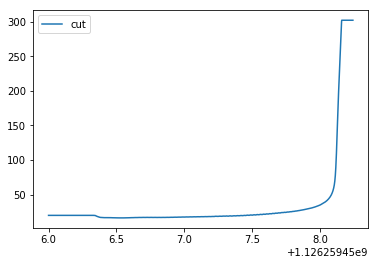

In [4]:
# smoothening

from statsmodels.nonparametric.smoothers_lowess import lowess

i_c=np.where(fGW==max(fGW))[0][0]

fGW_smooth = lowess(fGW[:i_c], wave_event_data["time"][:i_c], is_sorted=True, frac=0.025, it=0)[:,1]
fGW_smooth = np.lib.pad(fGW_smooth, (0,wave_event_data["time"].size-i_c), 'edge')

plt.figure()
plt.plot(wave_event_data["time"],fGW_smooth,label="cut")
plt.legend(loc = 'upper left')
plt.show()

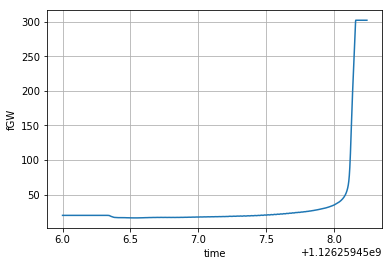

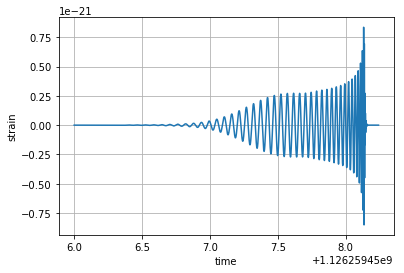

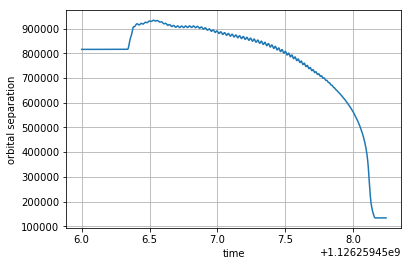

In [5]:
# computes orbital separation r

clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg
M_tot = 65.                           #  in solar masses; choose based on the template event

# calculating orbital separation
r = (G*M_tot*MSol/(4*(np.pi**2)*fGW_smooth**2))**(1./3)


time = wave_event_data["time"]

plt.figure()
plt.plot(time,fGW_smooth)
plt.grid()
plt.xlabel('time')
plt.ylabel('fGW')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

plt.figure()
plt.plot(time,wave_event_data["h_L1"])
plt.grid()
plt.xlabel('time')
plt.ylabel('strain')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

plt.figure()
plt.plot(time,r)
plt.grid()
plt.xlabel('time')
plt.ylabel('orbital separation')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

/Users/RMastandrea/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


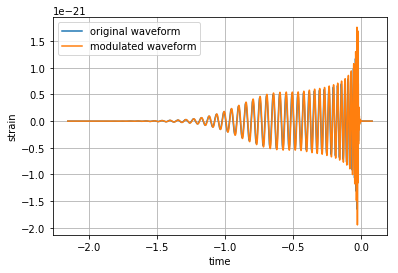

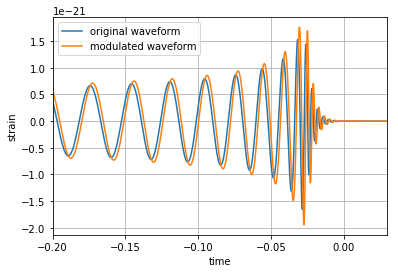

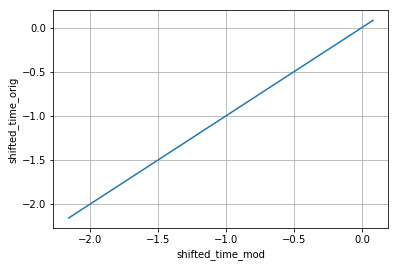

In [6]:
# now onto the lambda factor 

def shift_time(time,waveform):
    '''
    places peak of waveform at t=0
    '''
    tphase = np.absolute(np.unwrap(np.angle(waveform)))
    fGW = np.gradient(tphase)*fs/(2.*np.pi)
    iffix = np.where(np.absolute(waveform) < np.absolute(waveform).max()*0.001)[0]
    fGW[iffix] = fGW[iffix[0]-1]
    fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]
    return time-time[np.where(fGW==max(fGW))[0][0]]


def apply_modulation(waveform,r,lamda_amp,lamda_freq):
    '''
    modifies waveform based off of the exponential arg, 2 lambda factors
    '''
    waveform_fft = np.fft.fft(waveform)
    
    
    #plt.figure()
    #plt.plot(time,r)
    #plt.show()
    
    #plt.figure()
    #plt.plot(time,fGW_smooth)
    #plt.show()
    
    freqs=np.fft.fftfreq(waveform.size)*fs
    rnew = (G*M_tot*MSol/(4*(np.pi**2)*freqs**2))**(1./3)
    
    #plt.figure()
    #plt.plot(rnew)
    #plt.show()
    
    #plt.figure()
    #plt.plot(fGW_smooth,r,label="r")
    #plt.plot(freqs,rnew,label="rnew")
    #plt.legend("upper right")
    #plt.show()    
    
    #plt.figure()
    #plt.plot(time,freqs)
    #plt.show()
    
    exp_arg = (G*M_tot*MSol)/(rnew*clight**2) 
    mult_factor=np.exp((lamda_amp+1.j*lamda_freq)*exp_arg)
    
    #print exp_arg
    #print mult_factor
    mod_waveform_fft=waveform_fft*mult_factor
    mod_waveform=np.fft.ifft(mod_waveform_fft)
    return mod_waveform

shifted_time_orig = shift_time(wave_event_data["time"],waveform)
waveform_mod = apply_modulation(waveform,r,.5,2.5)
shifted_time_mod = shift_time(wave_event_data["time"],waveform_mod)

plt.figure()
plt.plot(shifted_time_orig,waveform,label="original waveform")
plt.plot(shifted_time_orig,waveform_mod,label="modulated waveform")
plt.grid()
plt.xlabel('time')
plt.ylabel('strain')
plt.legend(loc='upper left')
plt.show()


plt.figure()
plt.plot(shifted_time_mod,waveform,label="original waveform")
plt.plot(shifted_time_mod,waveform_mod,label="modulated waveform")
plt.grid()
plt.xlabel('time')
plt.xlim(-.2,.03)
plt.ylabel('strain')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(shifted_time_mod,shifted_time_orig)

plt.grid()
plt.xlabel('shifted_time_mod')
plt.ylabel('shifted_time_orig')
plt.show()

-1.03833007812 168.907083117


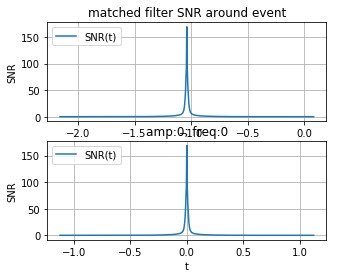

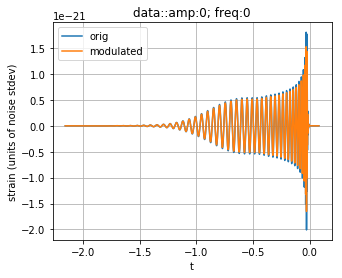

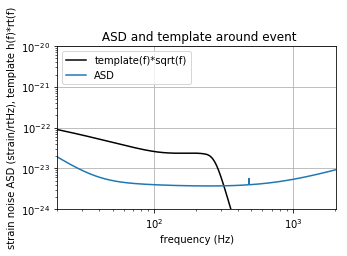

-1.0380859375 169.172792218


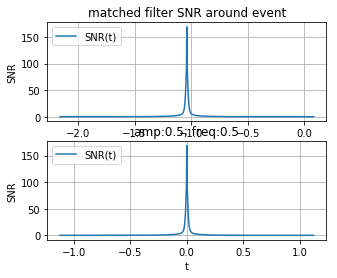

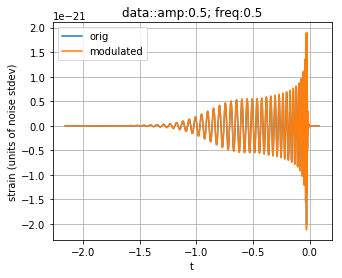

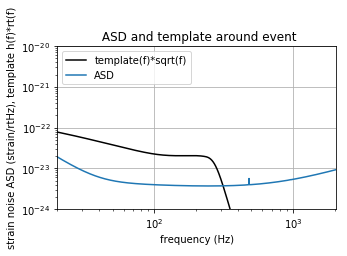

-1.0380859375 168.517882061


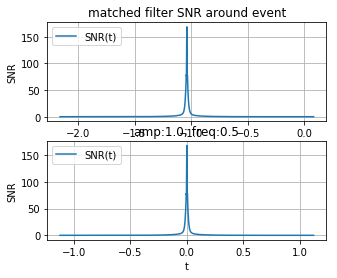

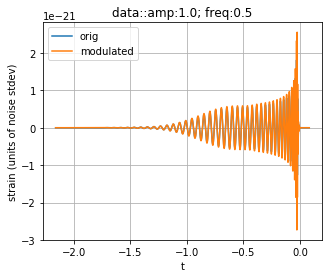

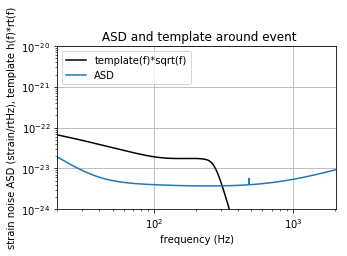

In [7]:
# testing a few vals


# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# complex waveform actual data; pick a random lambda_amp, lamda_freq
data_waveform = apply_modulation(waveform,r,.4,.6)


data_time = shift_time(wave_event_data["time"],data_waveform)
# We will record the time where the data match the END of the template.

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(data_waveform.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(data_waveform.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(data_waveform.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
data_fft = np.fft.fft(data_waveform*dwindow) / fs

 # -- Calculate the PSD of the data.  Also use an overlap, and window:
# using the newest asd file, padding the left end with extremelty high vals
asd_data=read_file(asd_file,asd_columns)
dfreq=asd_data["freq"][1]-asd_data["freq"][0]
first_freqs=np.arange(asd_data["freq"][0],-dfreq,-dfreq)[::-1]
full_freqs=np.append(first_freqs,asd_data["freq"])
full_strain = np.pad(asd_data["strain"],(first_freqs.size,0),'constant', constant_values=(10.e-10, 0))
asd_func = interpolate.interp1d(full_freqs, full_strain)
psd = (asd_func(np.abs(datafreq))**2)
    

# loop over the diff lambda vals
lamdas = [(0,0),(.5,.5),(1.,.5)]
for lamda in lamdas:

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    template_fft = np.fft.fft(apply_modulation(waveform,r,lamda[0],lamda[1])*dwindow) / fs
    
    # -- Interpolate to get the PSD values at the needed frequencies
    #power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = template_fft * data_fft.conjugate() / psd
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    #sigmasq = 1*(template_fft * template_fft.conjugate() / data_psd).sum() * df
    sigmasq = 1*(template_fft * template_fft.conjugate() / psd).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data_waveform.size / 2)  # location of peak in the template
    
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)
    
    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = data_time[indmax]
    SNRmax = SNR[indmax]
    
    print timemax,SNRmax
    
    string = "amp:"+str(lamda[0])+"; freq:"+str(lamda[1])
    
    plt.figure(figsize=(5,4))
    plt.subplot(2,1,1)
    plt.plot(data_time, SNR,label='SNR(t)')
    plt.grid('on')
    plt.ylabel('SNR')
    plt.xlabel('t')
    plt.legend(loc='upper left')
    plt.title('matched filter SNR around event')

    # zoom in
    plt.subplot(2,1,2)
    plt.plot(data_time-timemax, SNR,label='SNR(t)')
    plt.grid('on')
    plt.ylabel('SNR')
    #plt.xlim([-0.15,0.05])
    #plt.xlim([-0.3,+0.3])
    plt.grid('on')
    plt.xlabel('t')
    plt.legend(loc='upper left')
    plt.title(string)
    

    plt.figure(figsize=(5,4))
    plt.plot(data_time,data_waveform,label='orig')
    plt.plot(data_time,apply_modulation(waveform,r,lamda[0],lamda[1]),label='modulated')
    plt.grid('on')
    plt.xlabel('t')
    plt.ylabel('strain (units of noise stdev)')
    plt.legend(loc='upper left')
    plt.title('data::'+string)

    d_eff = sigma / SNRmax
                 
    # -- Display PSD and template
    # must multiply by sqrt(f) to plot template fft on top of ASD:
    plt.figure(figsize=(5,3))
    template_f = np.absolute(data_fft)*np.sqrt(np.abs(datafreq))  / d_eff
    plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
    plt.loglog(datafreq, np.sqrt(psd), label='ASD')
    plt.xlim(20, fs/2)
    plt.ylim(1e-24, 1e-20)
    plt.grid()
    plt.xlabel('frequency (Hz)')
    plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
    plt.legend(loc='upper left')
    plt.title(' ASD and template around event')
   
    plt.show()
    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)
    #print offset


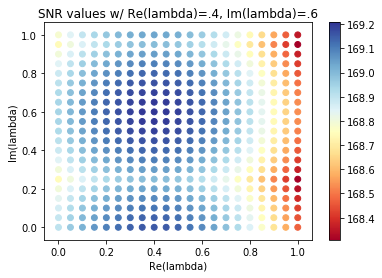

In [10]:
# grid method to maximize the SNR


# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# complex waveform actual data; pick a random lambda_amp, lamda_freq
data_waveform = apply_modulation(waveform,r,.4,.6)
data_time = shift_time(wave_event_data["time"],data_waveform)
# We will record the time where the data match the END of the template.

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(data_waveform.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(data_waveform.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(data_waveform.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
data_fft = np.fft.fft(data_waveform*dwindow) / fs

 # -- Calculate the PSD of the data.  Also use an overlap, and window:
# using the newest asd file, padding the left end with extremelty high vals
asd_data=read_file(asd_file,asd_columns)
dfreq=asd_data["freq"][1]-asd_data["freq"][0]
first_freqs=np.arange(asd_data["freq"][0],-dfreq,-dfreq)[::-1]
full_freqs=np.append(first_freqs,asd_data["freq"])
full_strain = np.pad(asd_data["strain"],(first_freqs.size,0),'constant', constant_values=(10.e-10, 0))
asd_func = interpolate.interp1d(full_freqs, full_strain)
psd = (asd_func(np.abs(datafreq))**2)
    

# loop over the diff lambda vals
lamda_amps = np.linspace(0,1,21)
lamda_freqs=np.linspace(0,1,21)

x = []
y = []
z = []

for amp in lamda_amps:
    for freq in lamda_freqs:
        # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
        template_fft = np.fft.fft(apply_modulation(waveform,r,amp,freq)*dwindow) / fs

        # -- Interpolate to get the PSD values at the needed frequencies
        #power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

        # -- Calculate the matched filter output in the time domain:
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
        # so the result will be plotted as a function of time off-set between the template and the data:
        optimal = template_fft * data_fft.conjugate() / psd
        optimal_time = 2*np.fft.ifft(optimal)*fs

        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        #sigmasq = 1*(template_fft * template_fft.conjugate() / data_psd).sum() * df
        sigmasq = 1*(template_fft * template_fft.conjugate() / psd).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time/sigma

        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data_waveform.size / 2)  # location of peak in the template

        SNR_complex = np.roll(SNR_complex,peaksample)
        SNR = abs(SNR_complex)

        # find the time and SNR value at maximum:
        indmax = np.argmax(SNR)
        timemax = data_time[indmax]
        SNRmax = SNR[indmax]

        x.append(amp)
        y.append(freq)
        z.append(SNRmax)
        
    

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(x, y, c=z, s=35, cmap=cm)
plt.colorbar(sc)
plt.xlabel("Re(lambda)")
plt.ylabel("Im(lambda)")
plt.title("SNR values w/ Re(lambda)=.4, Im(lambda)=.6")
plt.show()

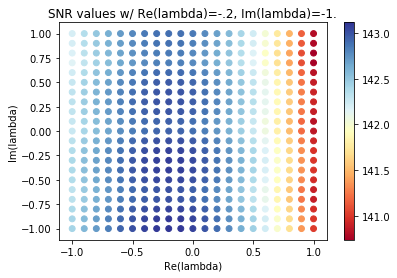

In [11]:
# grid method to maximize the SNR -- neg values


# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# complex waveform actual data; pick a random lambda_amp, lamda_freq
data_waveform = apply_modulation(waveform,r,-.2,-1.0)
data_time = shift_time(wave_event_data["time"],data_waveform)
# We will record the time where the data match the END of the template.

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(data_waveform.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(data_waveform.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(data_waveform.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
data_fft = np.fft.fft(data_waveform*dwindow) / fs

 # -- Calculate the PSD of the data.  Also use an overlap, and window:
# using the newest asd file, padding the left end with extremelty high vals
asd_data=read_file(asd_file,asd_columns)
dfreq=asd_data["freq"][1]-asd_data["freq"][0]
first_freqs=np.arange(asd_data["freq"][0],-dfreq,-dfreq)[::-1]
full_freqs=np.append(first_freqs,asd_data["freq"])
full_strain = np.pad(asd_data["strain"],(first_freqs.size,0),'constant', constant_values=(10.e-10, 0))
asd_func = interpolate.interp1d(full_freqs, full_strain)
psd = (asd_func(np.abs(datafreq))**2)
    

# loop over the diff lambda vals
lamda_amps = np.linspace(-1,1,21)
lamda_freqs=np.linspace(-1,1,21)

x = []
y = []
z = []

for amp in lamda_amps:
    for freq in lamda_freqs:
        # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
        template_fft = np.fft.fft(apply_modulation(waveform,r,amp,freq)*dwindow) / fs

        # -- Interpolate to get the PSD values at the needed frequencies
        #power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

        # -- Calculate the matched filter output in the time domain:
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
        # so the result will be plotted as a function of time off-set between the template and the data:
        optimal = template_fft * data_fft.conjugate() / psd
        optimal_time = 2*np.fft.ifft(optimal)*fs

        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        #sigmasq = 1*(template_fft * template_fft.conjugate() / data_psd).sum() * df
        sigmasq = 1*(template_fft * template_fft.conjugate() / psd).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time/sigma

        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data_waveform.size / 2)  # location of peak in the template

        SNR_complex = np.roll(SNR_complex,peaksample)
        SNR = abs(SNR_complex)

        # find the time and SNR value at maximum:
        indmax = np.argmax(SNR)
        timemax = data_time[indmax]
        SNRmax = SNR[indmax]

        x.append(amp)
        y.append(freq)
        z.append(SNRmax)
        
    

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(x, y, c=z, s=35, cmap=cm)
plt.colorbar(sc)
plt.xlabel("Re(lambda)")
plt.ylabel("Im(lambda)")
plt.title("SNR values w/ Re(lambda)=-.2, Im(lambda)=-1.")
plt.show()


In [ ]:
# grid method to maximize the SNR -- adding in white noise


# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# complex waveform actual data; pick a random lambda_amp, lamda_freq
data_waveform = apply_modulation(waveform,r,.4,.6)
data_time = shift_time(wave_event_data["time"],data_waveform)



plt.figure()
plt.plot(data_time,data_waveform,label="no noise")
plt.plot(data_time,data_waveform+np.random.normal(scale=.1e-21,size=data_waveform.size),label="noise")
plt.legend(loc='upper left')
plt.xlabel("time")
plt.ylabel("strain")
plt.show()
# We will record the time where the data match the END of the template.

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(data_waveform.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(data_waveform.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(data_waveform.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
data_fft = np.fft.fft((data_waveform+np.random.normal(scale=.1e-21,size=data_waveform.size))*dwindow) / fs

 # -- Calculate the PSD of the data.  Also use an overlap, and window:
# using the newest asd file, padding the left end with extremelty high vals
asd_data=read_file(asd_file,asd_columns)
dfreq=asd_data["freq"][1]-asd_data["freq"][0]
first_freqs=np.arange(asd_data["freq"][0],-dfreq,-dfreq)[::-1]
full_freqs=np.append(first_freqs,asd_data["freq"])
full_strain = np.pad(asd_data["strain"],(first_freqs.size,0),'constant', constant_values=(10.e-10, 0))
asd_func = interpolate.interp1d(full_freqs, full_strain)
psd = (asd_func(np.abs(datafreq))**2)
    

# loop over the diff lambda vals
lamda_amps = np.linspace(0,1,21)
lamda_freqs=np.linspace(0,1,21)

x = []
y = []
z = []

for amp in lamda_amps:
    for freq in lamda_freqs:
        # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
        template_fft = np.fft.fft(apply_modulation(waveform,r,amp,freq)*dwindow) / fs

        # -- Interpolate to get the PSD values at the needed frequencies
        #power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

        # -- Calculate the matched filter output in the time domain:
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
        # so the result will be plotted as a function of time off-set between the template and the data:
        optimal = template_fft * data_fft.conjugate() / psd
        optimal_time = 2*np.fft.ifft(optimal)*fs

        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        #sigmasq = 1*(template_fft * template_fft.conjugate() / data_psd).sum() * df
        sigmasq = 1*(template_fft * template_fft.conjugate() / psd).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time/sigma

        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data_waveform.size / 2)  # location of peak in the template

        SNR_complex = np.roll(SNR_complex,peaksample)
        SNR = abs(SNR_complex)

        # find the time and SNR value at maximum:
        indmax = np.argmax(SNR)
        timemax = data_time[indmax]
        SNRmax = SNR[indmax]

        x.append(amp)
        y.append(freq)
        z.append(SNRmax)
        
    

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(x, y, c=z, s=35, cmap=cm)
plt.colorbar(sc)
plt.xlabel("amp")
plt.xlabel("freq")
plt.title("SNR values w/ lambda_amp=.4, lambda_freq =.6; white noise added")
plt.show()




In [ ]:
from scipy.stats import rv_continuous
import pandas as pd
import numpy as np




def compute_bbh_params(num_events,filename):
    '''chi1L'''
    chi1L_events= np.array(np.random.uniform(0,1.,size=num_events))
    
    '''chi2L'''
    chi2L_events=np.array(np.random.uniform(0,1.,size=num_events))
    
    '''chip'''
    chip_events=np.array(np.random.uniform(0,1.,size=num_events))
    
    '''alpha'''
    alpha_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    
    '''psi'''
    psi_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    
    '''right ascension'''
    ra_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    
    '''phase'''
    phase_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    
    '''coalesence phase '''
    coal_phase_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    
    '''spin azimuthal angle'''
    spin_az_1_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    spin_az_2_events = np.array(np.random.uniform(0,2*np.pi,size=num_events))
    
    '''declination '''
    dec_events = np.arccos(np.array(np.random.uniform(-1,1,size=num_events)))
    
    '''inclination angle '''
    inc_events = np.arccos(np.array(np.random.uniform(-1,1,size=num_events)))
    
    '''spin polar angle'''
    spin_pol_1_events = np.arccos(np.array(np.random.uniform(-1,1,size=num_events)))
    spin_pol_2_events = np.arccos(np.array(np.random.uniform(-1,1,size=num_events)))
    
    '''spin magnitude '''
    spin_mean = .7
    spin_std_dev = .1
    class Spin_mag_pdf(rv_continuous):
        def _pdf(self, x):
            return (1.0/(2*np.pi*spin_std_dev**2)**.5)*np.exp(-(x-spin_mean)**2/(2*spin_std_dev**2))
    spin_mag_pdf = Spin_mag_pdf(name="Spin mag distribution", a=0,b=1)
    spin_mag_1_events = spin_mag_pdf.ppf(np.array(np.random.rand(num_events)))
    spin_mag_2_events = spin_mag_pdf.ppf(np.array(np.random.rand(num_events)))
    
    '''distance -- NORMED'''
    horizon_dist = 1.
    class Distance_pdf(rv_continuous):
        def _pdf(self, x):
            return 3.0*(x**2)*(1.0/horizon_dist)**3
    distance_pdf = Distance_pdf(name="Distance distribution", a=0,b=horizon_dist)
    distance_events=distance_pdf.ppf(np.array(np.random.rand(num_events)))

    '''mass'''
    min_bh_mass = .5 #default: .5, realistically ~2.5
    
    class Mass_pdf(rv_continuous):
        def _pdf(self, x):
            return 1.35*((2*min_bh_mass)**(1.35))*(x**(-2.35))
    mass_pdf = Mass_pdf(name="Mass distribution", a=2*min_bh_mass)
    y_hist_mtot=mass_pdf.ppf(np.array(np.random.rand(num_events))) #y_rand_tot is the list of random masses

    eta_std_dev=.05
    eta_mean=.25
    class Eta_pdf(rv_continuous):
        def _pdf(self, x):
            return (2.0/(2*np.pi*eta_std_dev**2)**.5)*np.exp(-(x-eta_mean)**2/(2*eta_std_dev**2))
    eta_pdf = Eta_pdf(name="Eta distribution", a=0,b=.25)
    y_hist_eta=eta_pdf.ppf(np.array(np.random.rand(num_events))) #y_rand_eta is the list of random etas

    m_1_events = .5*y_hist_mtot*(1+(1-4*y_hist_eta))
    m_2_events = .5*y_hist_mtot*(1-(1-4*y_hist_eta))
    
    '''coalesence time'''
    
    all_events = pd.DataFrame(
    {'ra': ra_events,
     'phase': phase_events,
     'coalesence phase': coal_phase_events,
     'spin azimuth 1': spin_az_1_events,
     'spin azimuth 2': spin_az_2_events,
     'declination': dec_events,
     'inclination': inc_events,
     'spin polar 1': spin_pol_1_events,
     'spin polar 2': spin_pol_2_events,
     'spin mag 1': spin_mag_1_events,
     'spin mag 2': spin_mag_2_events,
     'distance': distance_events,
     'm1': m_1_events,
     'm2': m_2_events,
     'chi1L': chi1L_events,
     'chi2L': chi2L_events,
     'chip': chip_events,
     'alpha': alpha_events,
     'psi': psi_events
     
    })
    
    
    all_events.to_csv(filename)
    
    return all_events
    
    






compute_bbh_params(10000,"10000_BBH_events_updated.txt")

print "done mofo"



In [ ]:
import pandas as pd
import numpy as np
def read_bbh_file(filename, num_lines):
    df = pd.read_csv("10000_BBH_events.txt", nrows=num_lines)
    all_param_dicts = {}
    for i in range(num_lines):
        params = {}
        params['m1_det']=df["m1"][i]
        params['m2_det']=df["m2"][i]
        params['m1_source']=df["m1"][i]
        params['m2_source']=df["m2"][i]
        params['s1x']= df["spin mag 1"][i]*np.sin(df["spin polar 1"][i])*np.cos(df["spin azimuth 1"][i])
        params['s1y']= df["spin mag 1"][i]*np.sin(df["spin polar 1"][i])*np.sin(df["spin azimuth 1"][i])
        params['s1z']= df["spin mag 1"][i]*np.cos(df["spin polar 1"][i])
        params['s2x']= df["spin mag 2"][i]*np.sin(df["spin polar 2"][i])*np.cos(df["spin azimuth 2"][i])
        params['s2y']= df["spin mag 2"][i]*np.sin(df["spin polar 2"][i])*np.sin(df["spin azimuth 2"][i])
        params['s2z']= df["spin mag 2"][i]*np.cos(df["spin polar 2"][i])
        params['luminosity_distance']=df["distance"][i]
        params['iota']=df["inclination"][i]
        params['chi1L']= df["chi1L"][i]
        params['chi2L']= df["chi2L"][i]
        params['chip']= df["chip"][i]
        params['alpha']= df["alpha"][i]
        params['psi']= df["psi"][i]
        params['ra']= df["ra"][i]
        params['dec']=df["declination"][i]
        params['psi_c']= df["coalesence phase"][i]
        params['phiRef']= df["phase"][i]
        params['fmin']= 20
        params['fref']= 400
        params['time']= np.random.random()
        params['redshift']= np.random.random()
        params['ampOrder']= ""
        params['phOrder']= ""
        params['approx']= 'IMRPhenomD'
        
        
        all_param_dicts[str(i)] = params
        
    return all_param_dicts
   
    
    

    
    
    
    
print read_bbh_file("10000_BBH_events.txt",5)